# Imports and Setup
This cell imports all the required libraries and sets up the environment.

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    get_cosine_schedule_with_warmup
)

!pip install datasets
from datasets import Dataset

# Disable W&B logs
os.environ["WANDB_DISABLED"] = "true"

## Exploratory Data Analysis (EDA)
This cell loads the data and performs some basic EDA including visualizations for the distribution of ratings and the lengths of review texts.

Dataset Shape: (1597, 27)
Dataset Head:


,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


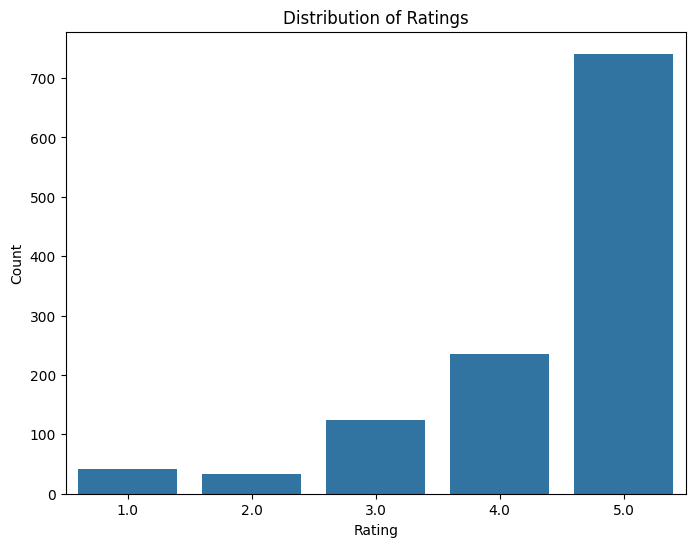

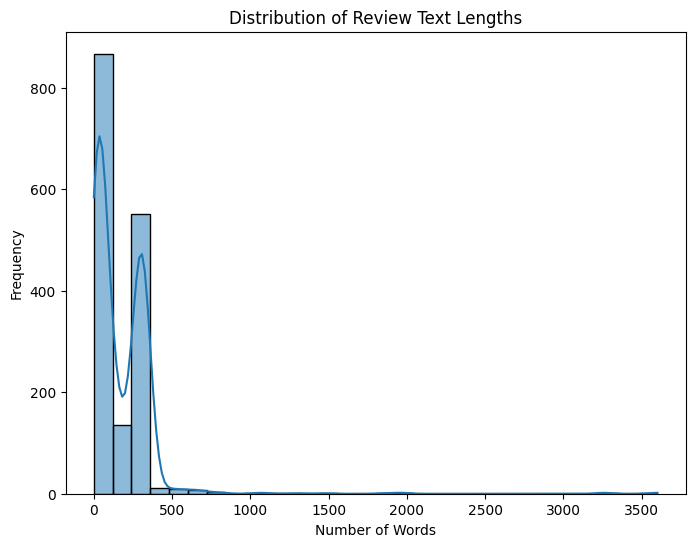

In [ ]:
file_path = "reviews.csv"
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Dataset Head:")
display(data.head())

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Plot distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="reviews.rating")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Calculate text lengths (word count) for each review
data['text_length'] = data["reviews.text"].apply(lambda x: len(str(x).split()))

# Plot distribution of text lengths
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='text_length', bins=30, kde=True)
plt.title("Distribution of Review Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

## Data Preprocessing and Oversampling
This cell checks for the required columns, preprocesses the data, and applies oversampling to handle class imbalance.

In [ ]:
# Check required columns
text_column = "reviews.text"
label_column = "reviews.rating"

if text_column not in data.columns or label_column not in data.columns:
    raise KeyError(f"Columns '{text_column}' and '{label_column}' must exist in the dataset.")

# Preprocess data
data = data[[text_column, label_column]].dropna()
label_encoder = LabelEncoder()
data[label_column] = label_encoder.fit_transform(data[label_column])

# Oversample minority classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(data[[text_column]], data[label_column])
data = pd.DataFrame({text_column: X_resampled[text_column], label_column: y_resampled})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


## Train-Test Split and Class Weights Computation
This cell splits the data into training and testing sets and computes class weights to handle class imbalance during training.

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data[text_column], data[label_column],
    test_size=0.2,
    random_state=42,
    stratify=data[label_column]
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

## Load Model and Tokenizer
This cell loads the pre-trained RoBERTa model and its tokenizer from the Transformers library.

In [ ]:
# Load model and tokenizer (using RoBERTa for better performance)
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create Hugging Face Datasets and Tokenize Data
This cell creates the training and testing datasets using the Hugging Face `Dataset` class and applies tokenization to the text data.

In [ ]:
# Create datasets
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2964 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

## Custom Trainer with Class Weights
This cell defines a custom Trainer that incorporates class weights into the loss computation and also defines the metric calculation function.

In [ ]:
# Custom trainer with class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Metrics calculation
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'macro_f1': f1_score(p.label_ids, preds, average='macro'),
        'macro_precision': precision_score(p.label_ids, preds, average='macro'),
        'macro_recall': recall_score(p.label_ids, preds, average='macro'),
        'weighted_f1': f1_score(p.label_ids, preds, average='weighted')
    }

## Training Arguments and Trainer Initialization
This cell sets up the training arguments and initializes the Trainer with the custom settings.

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
    greater_is_better=True,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none",
    warmup_steps=100
)

# Initialize trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Model Training
This cell starts the training process for the model.

In [ ]:
# Train model
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Weighted F1
1,1.612300,1.380035,0.409054,0.513550,0.445737,0.408822
2,0.966600,0.481105,0.804297,0.809461,0.805777,0.804128
3,0.394600,0.302183,0.882966,0.882363,0.884156,0.882780
4,0.232600,0.215352,0.913362,0.917071,0.913695,0.913218
5,0.167500,0.195650,0.925782,0.926200,0.925884,0.925648


TrainOutput(global_step=465, training_loss=0.6468418249519923, metrics={'train_runtime': 867.8856, 'train_samples_per_second': 17.076, 'train_steps_per_second': 0.536, 'total_flos': 1949705435658240.0, 'train_loss': 0.6468418249519923, 'epoch': 5.0})

## Final Evaluation and Metrics
This cell evaluates the trained model on the test set and prints out the classification report along with additional metrics.

In [ ]:
# Final evaluation
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)

# Generate classification report
target_names = [str(label) for label in label_encoder.classes_]
print("\nClassification Report:")
print(classification_report(
    y_test,
    preds,
    target_names=target_names,
    digits=4
))

# Calculate and print additional metrics
print(f"Macro F1: {f1_score(y_test, preds, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(y_test, preds, average='weighted'):.4f}")
print(f"Balanced Accuracy: {recall_score(y_test, preds, average='macro'):.4f}")


Classification Report:
              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000       148
         2.0     1.0000    1.0000    1.0000       148
         3.0     0.9600    0.9730    0.9664       148
         4.0     0.8077    0.8456    0.8262       149
         5.0     0.8633    0.8108    0.8362       148

    accuracy                         0.9258       741
   macro avg     0.9262    0.9259    0.9258       741
weighted avg     0.9260    0.9258    0.9256       741

Macro F1: 0.9258
Weighted F1: 0.9256
Balanced Accuracy: 0.9259
